### Feature Selection for Grit Score Prediction

In this notebook, we perform three feature selection techniques to identify the most important survey questions for predicting grit score:

1. Correlation-based filtering
2. Lasso-based feature selection  
3. Recursive Feature Elimination (RFE) with Linear Regression

We use only the columns specified in our selected feature list (E1–E10, N1–N10, A1–A10, C1–C10, O1–O10,age groups, vocab score and martial status).

The goal is to reduce noise, understand which questions matter most, and prepare a strong feature subset for advanced modeling.


#### Importing required libraries

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE

import matplotlib.pyplot as plt

#### Loading the Dataset

In [2]:
df = pd.read_csv('data/engineered_grit_data.csv')
df.head()

,surveyelapse,VCL1,VCL2,VCL3,VCL4,VCL5,VCL7,VCL8,VCL10,VCL11,...,operatingsystem_ChromeOS,operatingsystem_Linux,operatingsystem_Macintosh,operatingsystem_Unknown,operatingsystem_Windows,operatingsystem_Windows Phone,operatingsystem_iOS,age_group_18-30,age_group_30-45,age_group_45+
0,340,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,126,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,1,0
2,130,1,1,1,1,1,0,1,1,1,...,0,0,0,0,1,0,0,0,0,1
3,592,1,0,0,1,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
4,217,1,1,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0


#### Selecting required columns

In [3]:
columns = ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'N1', 'N2',
       'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'A1', 'A2', 'A3', 'A4',
       'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
       'C7', 'C8', 'C9', 'C10', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8',
       'O9', 'O10', 'age_group_18-30', 'age_group_30-45',
       'age_group_45+', 'vocab_score', 'married_Currently married',
       'married_Never married', 'married_Previously married']

target = "Grit"

In [4]:
df = df[columns + [target]]
df.head()

,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,...,O9,O10,age_group_18-30,age_group_30-45,age_group_45+,vocab_score,married_Currently married,married_Never married,married_Previously married,Grit
0,1,1,1,1,2,1,1,1,1,2,...,3,2,0,1,0,3,1,0,0,3.083333
1,4,5,3,4,3,5,4,4,5,3,...,5,5,0,1,0,12,0,0,1,2.583333
2,3,5,5,5,5,5,4,4,4,4,...,4,5,0,0,1,11,0,0,1,4.250000
3,5,3,3,3,5,1,3,3,3,1,...,3,3,0,0,1,5,0,0,1,3.166667
4,1,2,1,1,1,3,3,5,2,1,...,5,5,1,0,0,6,0,1,0,2.000000


#### Correlation-Based Feature Selection

We compute the Pearson correlation between each feature and Grit and keep only those above a threshold.


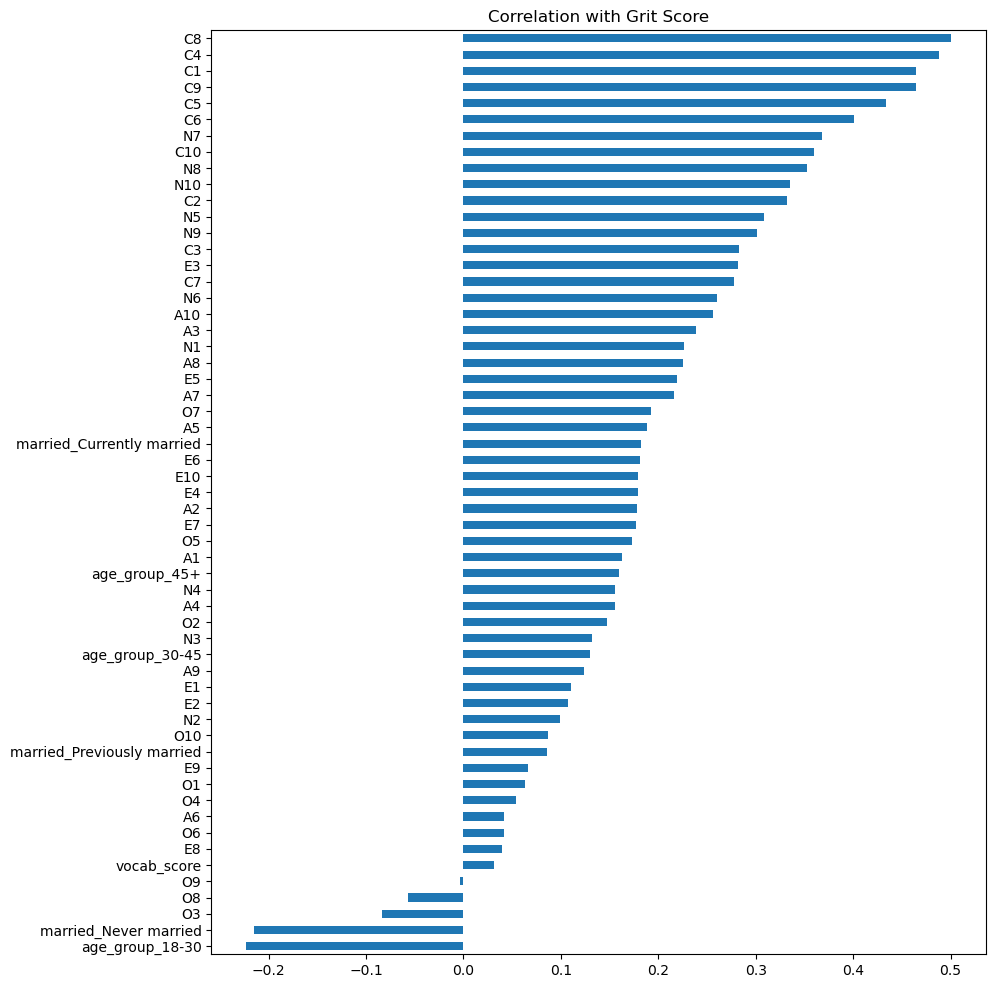

E1    0.110668
E2    0.107363
E3    0.281373
E4    0.179027
E5    0.219657
Name: Grit, dtype: float64

In [ ]:
corr = df[columns + [target]].corr()[target].drop(target)

plt.figure(figsize=(10, 12))
corr.sort_values().plot(kind="barh")
plt.title("Correlation with Grit Score")
plt.show()

corr.head()


In [9]:
def select_by_correlation(corr_series, threshold=0.10):
    """
    Returns features with absolute correlation >= threshold.
    """
    return corr_series[abs(corr_series) >= threshold].index.tolist()

threshold = 0.10
selected_corr_features = select_by_correlation(corr, threshold)

len(selected_corr_features)

44

Updating the columns to selected_corr_features

In [10]:
columns = selected_corr_features

X = df[columns]
y = df[target]

#### Lasso Feature Selection

We use LassoCV to shrink coefficients and select only the most relevant features.


In [12]:
lasso = LassoCV(cv=5, random_state=42, max_iter=5000)

lasso.fit(X, y)

LassoCV(cv=5, max_iter=5000, random_state=42)

In [13]:
lasso_coefs = pd.Series(lasso.coef_, index=X.columns)

In [18]:
lasso_selected = lasso_coefs[lasso_coefs != 0].sort_values(ascending=False)

selected_lasso_features = list(lasso_selected.index)

len(selected_lasso_features)

33

Updating the columns to have only selected_lasso_features features

In [19]:
columns = selected_lasso_features

X = df[columns]
y = df[target]

#### Recursive Feature Elimination (RFE)

We use RFE with Linear Regression to rank features and extract the top 15 most important.

In [28]:
linreg = LinearRegression()
rfe = RFE(estimator=linreg, n_features_to_select=15)
rfe.fit(X, y)

RFE(estimator=LinearRegression(), n_features_to_select=15)

In [29]:
rfe_ranking = pd.Series(rfe.ranking_, index=X.columns)
selected_rfe = rfe_ranking[rfe_ranking == 1].index.tolist()

In [30]:
print("Top 15 Features (RFE):")
selected_rfe

Top 15 Features (RFE):


['C8',
 'C9',
 'C1',
 'C10',
 'C5',
 'C4',
 'N7',
 'C3',
 'A10',
 'C2',
 'N5',
 'A8',
 'O2',
 'E10',
 'age_group_18-30']

In [32]:
columns = selected_rfe

In [33]:
print(columns)

['C8', 'C9', 'C1', 'C10', 'C5', 'C4', 'N7', 'C3', 'A10', 'C2', 'N5', 'A8', 'O2', 'E10', 'age_group_18-30']
